<a href="https://colab.research.google.com/github/IsadoraPrevitalle/TCC-Eficiencia_RedesNeurais_PrevisaoSeriesFinanceiras/blob/main/LSTM_flutua%C3%A7%C3%A3o_financeira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM - Previsão de flutuações financeiras (Petrobrás)
link de referencia: https://youtu.be/QSR0RCC3Mes?si=O3ahqRv-nir9T3Uj

In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
from platform import python_version
print(python_version())

3.10.12


A base representa dados históricos de preço de ações do ibovespa (https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/) entre o periodo de 2020 a 2022. Para compactar essa base foi necessário desenvolver o processo ETL da mesma: https://
youtu.be/gew9014pGaM?si=h3Ymw2m7kf22-IzP


---





In [ ]:
df = pd.read_csv('all_bovespaCor.csv', sep=',')
df

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_max,preco_min,preco_fechamento,qtd_negocios,volume_negocios
0,2020-01-02,AALR3,ALLIAR,1829.0,1900.0,1828.0,19.00,585800.0,1.094620e+09
1,2020-01-02,AAPL34,APPLE,12000.0,12134.0,12000.0,121.34,12700.0,1.533380e+08
2,2020-01-02,ABCB4,ABC BRASIL,2000.0,2030.0,1982.0,20.30,870400.0,1.745788e+09
3,2020-01-02,ABEV3,AMBEV S/A,1886.0,1925.0,1878.0,19.20,16011300.0,3.062348e+10
4,2020-01-02,ADHM3,ADVANCED-DH,255.0,255.0,235.0,2.48,193400.0,4.719270e+07
...,...,...,...,...,...,...,...,...,...
500826,2022-11-25,EMAE4,EMAE,4000.0,4108.0,4000.0,41.08,600.0,2.417400e+06
500827,2022-11-25,EMBR3,EMBRAER,1450.0,1464.0,1430.0,14.31,3989300.0,5.763856e+09
500828,2022-11-25,INEP3,INEPAR,120.0,134.0,118.0,1.26,7311600.0,9.272758e+08
500829,2022-11-25,INEP4,INEPAR,109.0,120.0,105.0,1.11,2672500.0,3.037508e+08


A ação utilizada para realizar a previsão do modelo foi a da Petrobras, de acordo com suas cotações de fechamento entre o periodo do dia 02 de janeiro de 2020 até o dia 29 de dezembro de 2022.
Um total de 746 linhas.

---



In [ ]:
#Escolhendo a ação e criando um novo df que terá as colunas utilizadas no modleo LSTM (Data e preço)
df_acao = df [df['sigla_acao'] == 'PETR4']
df_acao = df_acao.sort_values(by='data_pregao')
df_acao_fec = df_acao[['data_pregao', 'preco_fechamento']]
df_acao_fec

,data_pregao,preco_fechamento
262,2020-01-02,30.70
997,2020-01-03,30.45
998,2020-01-06,30.81
2550,2020-01-07,30.69
2551,2020-01-08,30.50
...,...,...
466738,2022-12-23,25.12
466614,2022-12-26,24.94
467539,2022-12-27,25.11
476902,2022-12-28,24.80


In [ ]:
df_teste = df_acao_fec
df_teste['data_pregao'] = pd.to_datetime(df_teste['data_pregao'])
df_teste.set_index('data_pregao', inplace=True)

In [ ]:
df_teste

,preco_fechamento
data_pregao,
2020-01-02,30.70
2020-01-03,30.45
2020-01-06,30.81
2020-01-07,30.69
2020-01-08,30.50
...,...
2022-12-23,25.12
2022-12-26,24.94
2022-12-27,25.11


In [ ]:
df_acao_fec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2020-01-02 to 2022-12-29
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   preco_fechamento  746 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB


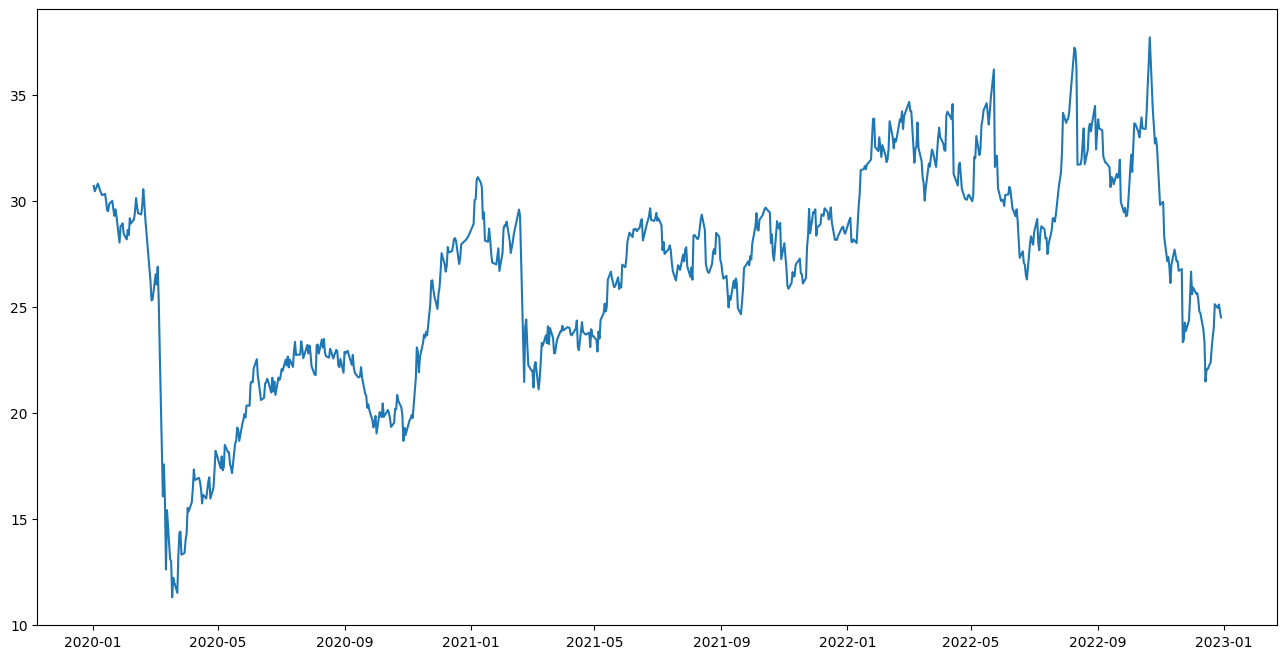

In [ ]:
#Grafico de como está as flutuaçãoes desse periodo
plt.figure(figsize=(16,8))
plt.plot(df_acao_fec['preco_fechamento'])


In [ ]:
#Ajuste dos dados com rashape para o modelo de LSTM
cotacao = df_acao_fec['preco_fechamento'].to_numpy().reshape(-1, 1)
#cotacao

array([[30.7 ],
       [30.45],
       [30.81],
       [30.69],
       [30.5 ],
       [30.4 ],
       [30.27],
       [30.33],
       [30.  ],
       [29.55],
       [29.52],
       [29.85],
       [30.  ],
       [29.62],
       [29.29],
       [29.6 ],
       [29.3 ],
       [28.03],
       [28.8 ],
       [28.85],
       [28.94],
       [28.45],
       [28.18],
       [28.63],
       [28.39],
       [29.18],
       [28.93],
       [29.13],
       [29.48],
       [30.13],
       [29.72],
       [29.42],
       [29.36],
       [29.75],
       [30.55],
       [29.92],
       [29.14],
       [26.21],
       [25.3 ],
       [25.34],
       [26.53],
       [26.05],
       [26.89],
       [25.29],
       [22.83],
       [16.05],
       [17.56],
       [15.85],
       [12.6 ],
       [15.4 ],
       [13.09],
       [13.  ],
       [11.29],
       [12.21],
       [12.  ],
       [11.5 ],
       [13.25],
       [14.32],
       [14.39],
       [13.3 ],
       [13.38],
       [13.99],
       [

**80% dos dados iniciais | 80% de dados aleatórios**

---



In [ ]:
#Pega 80% dos dados iniciais da base - 596 registros
tamanho_dados_treinamento = int(len(cotacao) * 0.8)
tamanho_dados_treinamento

596

In [ ]:
#Escalar os dados entre 0 e 1, para deixar mais fácil o processamento

escalador = MinMaxScaler(feature_range=(0, 1))
#Treino - 596 registros da cotação de tamanho_dados_treinamento
dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])
#Teste - 150 registros restantes para teste
dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

#Junta os dados
dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))

#Faz reshape desses novos dados
dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

Cria-se os dados de treino e teste com 60 dias para previsão de 1

---



In [ ]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.77920514, 0.76916901, 0.78362104, 0.77880369, 0.77117623,
       0.76716178, 0.76194299, 0.76435167, 0.75110397, 0.73303894,
       0.7318346 , 0.7450823 , 0.75110397, 0.73584906, 0.72260136,
       0.73504617, 0.72300281, 0.67201927, 0.70293055, 0.70493778,
       0.70855078, 0.68887997, 0.67804095, 0.69610598, 0.6864713 ,
       0.71818547, 0.70814934, 0.71617824, 0.73022882, 0.75632276,
       0.73986351, 0.72782015, 0.72541148, 0.74106784, 0.77318346,
       0.74789241, 0.71657969, 0.59895624, 0.56242473, 0.56403051,
       0.61180249, 0.59253312, 0.62625452, 0.56202328, 0.46326776,
       0.19108792, 0.25170614, 0.18305901, 0.05258932, 0.16499398,
       0.07226014, 0.06864713, 0.        , 0.03693296, 0.02850261,
       0.00843035, 0.07868326, 0.1216379 , 0.12444801, 0.08069049])]
[0.08390204737053397]
[array([0.77920514, 0.76916901, 0.78362104, 0.77880369, 0.77117623,
       0.76716178, 0.76194299, 0.76435167, 0.75110397, 0.73303894,
       0.7318346 , 0.7450823 , 0.751

In [ ]:
#transformando as listas em arrays e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

treinamento_x

array([[[0.77920514],
        [0.76916901],
        [0.78362104],
        ...,
        [0.1216379 ],
        [0.12444801],
        [0.08069049]],

       [[0.76916901],
        [0.78362104],
        [0.77880369],
        ...,
        [0.12444801],
        [0.08069049],
        [0.08390205]],

       [[0.78362104],
        [0.77880369],
        [0.77117623],
        ...,
        [0.08069049],
        [0.08390205],
        [0.1083902 ]],

       ...,

       [[0.92051385],
        [0.8871939 ],
        [0.91168206],
        ...,
        [0.91850662],
        [0.94500201],
        [1.        ]],

       [[0.8871939 ],
        [0.91168206],
        [0.93857888],
        ...,
        [0.94500201],
        [1.        ],
        [0.81533521]],

       [[0.91168206],
        [0.93857888],
        [0.92131674],
        ...,
        [1.        ],
        [0.81533521],
        [0.83340024]]])

Construção do Modelo na arquitetura de 50 neuronios


---



In [ ]:
modelo = Sequential()

#Criar um modelo com 50 neurônios
#Return sequences = True pois vamos usar outro LSTM de 50 depois.
#Definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))


Copilando o modelo, utilizando a medida de erro médio quadrático para avalia-lo


---



In [ ]:
#A função de loss é a forma de medir o erro do modelo, que nesse caso é o erro médio quadrático usado em regressão linear

modelo.compile(optimizer="adam", loss="mean_squared_error")

Treinamento do modelo


---



In [ ]:
#Batch_size - Parametros de otimização a cada quantidade de amostra (nesse caso 1)
#Epochs - quantas vezes o modelo vai rodar nos dados de treinamento (nesse caso 1)
modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

536/536 [==============================] - 29s 46ms/step - loss: 0.0079


Criando os dados de teste - 20% dos dados finais da base


---



In [ ]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])


In [ ]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

Realizando as predições dos dados de teste x


---



In [ ]:
predicoes = modelo.predict(teste_x)

#Invertendo a transformaçãoo entre 0 e 1
predicoes = escalador.inverse_transform(predicoes)
predicoes

5/5 [==============================] - 1s 19ms/step


array([[33.076553],
       [32.653538],
       [32.14495 ],
       [31.641685],
       [31.180246],
       [30.76151 ],
       [30.451355],
       [30.229845],
       [30.111614],
       [30.050201],
       [29.992975],
       [29.912197],
       [29.796179],
       [29.700453],
       [29.57789 ],
       [29.305223],
       [29.008123],
       [28.672346],
       [28.339622],
       [27.995855],
       [27.662071],
       [27.5026  ],
       [27.476616],
       [27.510595],
       [27.5681  ],
       [27.686174],
       [27.876928],
       [27.998133],
       [28.046104],
       [28.116007],
       [28.21272 ],
       [28.302767],
       [28.346203],
       [28.362959],
       [28.298302],
       [28.235458],
       [28.228006],
       [28.297464],
       [28.401918],
       [28.506432],
       [28.629606],
       [28.866505],
       [29.166786],
       [29.506382],
       [29.918459],
       [30.491158],
       [31.054428],
       [31.580696],
       [32.04178 ],
       [32.451527],


In [ ]:
#pegando o erro médio quadrático (RMSE) - reais
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.06487146046956385

Gráfico do Modelo LSTM


---



In [ ]:
treinamento = df_acao_fec.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"preco_fechamento": df_acao_fec['preco_fechamento'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


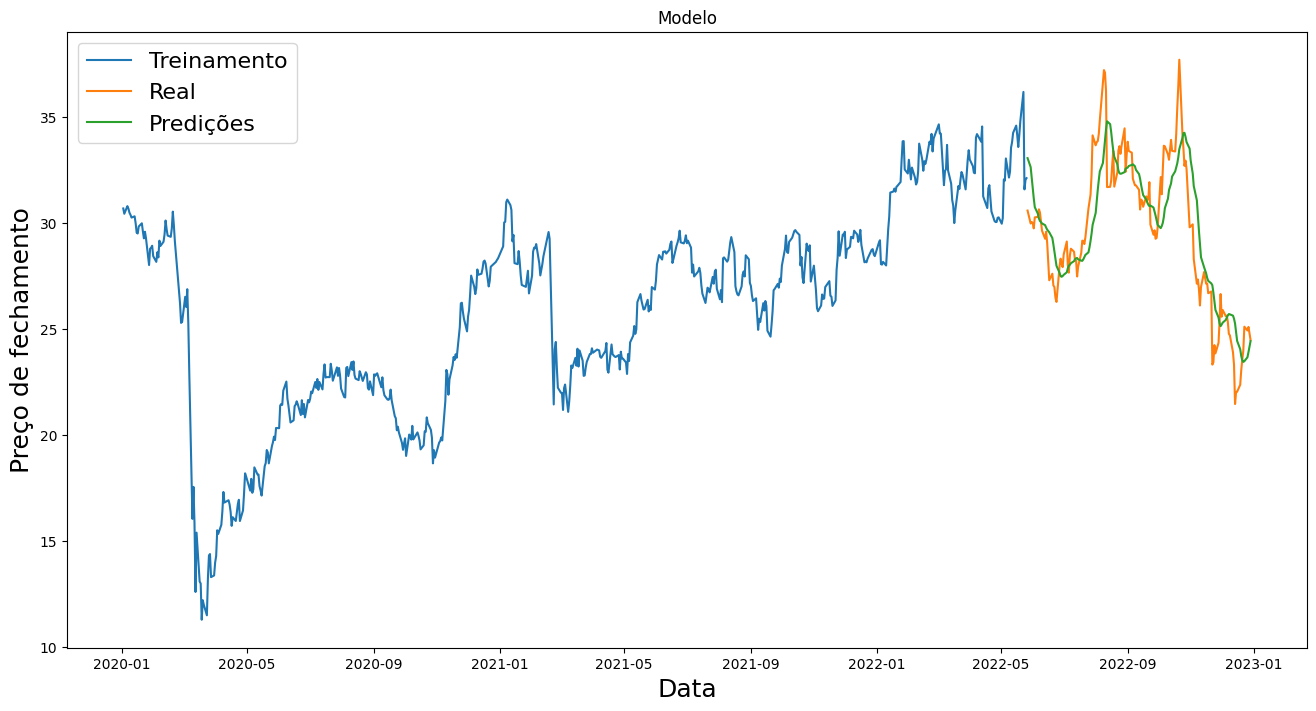

In [ ]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['preco_fechamento'])
plt.plot(df_teste[['preco_fechamento', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [ ]:
#Dados reais e dados de teste previstos pelo modelo
df_teste.sort_index()
df_teste

,preco_fechamento,predicoes
data_pregao,,
2022-05-27,30.60,33.076553
2022-05-30,29.99,32.653538
2022-05-31,30.06,32.144951
2022-06-01,30.02,31.641685
2022-06-02,29.76,31.180246
...,...,...
2022-12-23,25.12,23.490784
2022-12-26,24.94,23.676655
2022-12-27,25.11,23.919886


**Recomendações de compra ou venda - queda ou subida dos valores**

In [ ]:
#calcular media de acertos e expectativa de lucro
# 1 acerto - 0 erro
# Variação absoluta - calculo de ganho e perda

df_teste['variacao_percentual_acao'] = df_teste['preco_fechamento'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0,
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0,
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

<ipython-input-34-13dd04755fef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0,
<ipython-input-34-13dd04755fef>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0,
<ipython-input-34-13dd04755fef>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,preco_fechamento,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
data_pregao,,,,,,,,
2022-05-30,29.99,32.653538,-0.019935,-0.012789,False,False,True,0.019935
2022-05-31,30.06,32.144951,0.002334,-0.015575,True,False,False,0.002334
2022-06-01,30.02,31.641685,-0.001331,-0.015656,False,False,True,0.001331
2022-06-02,29.76,31.180246,-0.008661,-0.014583,False,False,True,0.008661
2022-06-03,30.28,30.761511,0.017473,-0.013430,True,False,False,0.017473
...,...,...,...,...,...,...,...,...
2022-12-23,25.12,23.490784,0.047103,0.001456,True,True,True,0.047103
2022-12-26,24.94,23.676655,-0.007166,0.007913,False,True,False,0.007166
2022-12-27,25.11,23.919886,0.006816,0.010273,True,True,True,0.006816


In [ ]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print("Acertos por dia do modelo: ",acertou_lado)
print("Média de lucro do modelo: ",exp_mat_lucro * 100)

acertou_o_lado
False    0.020243
True     0.023189
Name: variacao_percentual_acao_abs, dtype: float64
1.145496663014125
Acertos por dia do modelo:  0.47651006711409394
Média de lucro do modelo:  0.04524528935081467


Matriz de confusão

In [ ]:
valores_selecionados = len(df_teste[df_teste['var_acao_maior_menor_que_zero'] == True]['var_acao_maior_menor_que_zero'])
print(valores_selecionados)


77


In [ ]:
valores_selecionados = len(df_teste[df_teste['var_acao_maior_menor_que_zero'] == False]['var_acao_maior_menor_que_zero'])
print(valores_selecionados)


72


In [ ]:
valores_selecionados = len(df_teste[df_teste['var_modelo_maior_menor_que_zero'] == True]['var_modelo_maior_menor_que_zero'])
print(valores_selecionados)


65


In [ ]:
valores_selecionados = len(df_teste[df_teste['var_modelo_maior_menor_que_zero'] == False]['var_modelo_maior_menor_que_zero'])
print(valores_selecionados)


84


In [ ]:
valores_selecionados = len(df_teste[df_teste['acertou_o_lado'] == True]['acertou_o_lado'])
print(valores_selecionados)


71


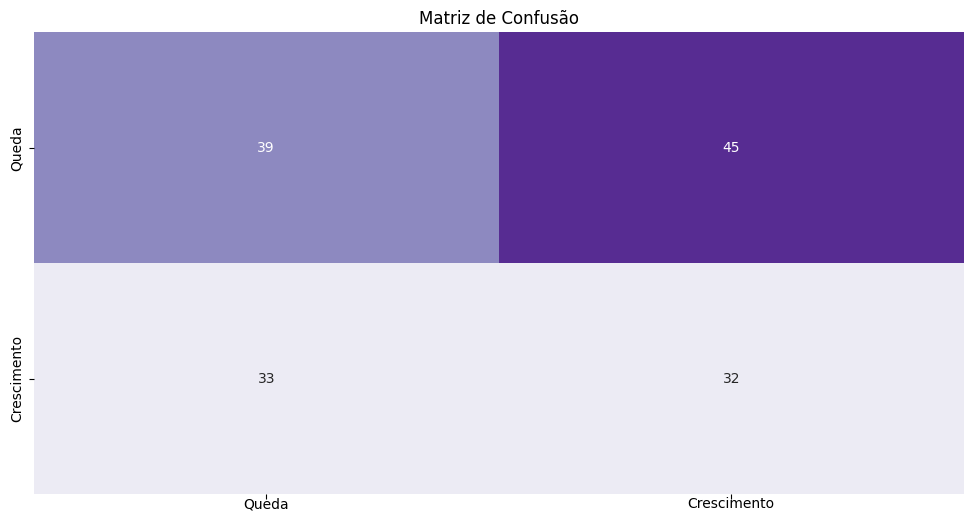

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(confusion_matrix(df_teste['var_modelo_maior_menor_que_zero'],df_teste['var_acao_maior_menor_que_zero']), annot=True, fmt='d', cmap=sns.color_palette ("Purples"), cbar=False, ax=ax)
plt.title("Matriz de Confusão")
ax.xaxis.set_ticklabels(['Queda','Crescimento'], va='center')
ax.yaxis.set_ticklabels(['Queda','Crescimento'], va='center')
plt.show()